In [3]:
%matplotlib inline

In [4]:
# Import necessary libraries
import pandas as pd
from datasets import load_dataset
import re
import unicodedata
import contractions
import nltk
from collections import Counter
from textstat import flesch_reading_ease, syllable_count
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# Get the dataset from Hello-SimpleAI/HC3
dataset = load_dataset("Hello-SimpleAI/HC3", "all")
df = pd.DataFrame(dataset["train"])

# Take a look at the dataset
df.head()

,id,question,human_answers,chatgpt_answers,source
0,0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,reddit_eli5
1,1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,reddit_eli5
2,2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,reddit_eli5
3,3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,reddit_eli5
4,4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,reddit_eli5


In [9]:
# Explode the human and ChatGPT answers so that each answer gets its own row
df = df.explode("human_answers").explode("chatgpt_answers")

# Create a new DataFrame for human and ChatGPT answers separately
df_human = pd.DataFrame({"text": df["human_answers"], "classification": 1})
df_chatgpt = pd.DataFrame({"text": df["chatgpt_answers"], "classification": 0})

# Concatenate both DataFrames
df_combined = pd.concat([df_human, df_chatgpt], ignore_index=True)

# Drop NaN values that might result from the explosion
df_combined = df_combined.dropna().reset_index(drop=True)

In [10]:
print(df_combined)

                                                     text  classification
0       Basically there are many categories of " Best ...               1
1       If you 're hearing about it , it 's because it...               1
2       One reason is lots of catagories . However , h...               1
3       salt is good for not dying in car crashes and ...               1
4       In Minnesota and North Dakota , they tend to u...               1
...                                                   ...             ...
121806  It's not uncommon for blood pressure to fluctu...               0
121807  There are several possible causes of a painles...               0
121808  It is not appropriate for me to recommend a sp...               0
121809  It is not uncommon for people with rheumatoid ...               0
121810  It is not uncommon to experience back pain, es...               0

[121811 rows x 2 columns]


In [12]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to count words
def word_count(text):
    return len(word_tokenize(text))

# Load the cleaned dataset (assuming df_combined is already prepared)
df = df_combined.copy()

# Step 1: Original Word Count
df["original_word_count"] = df["text"].apply(word_count)

# Step 2: Text Cleaning (Removing special characters, extra spaces, URLs, numbers)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["cleaned_text"] = df["text"].apply(clean_text)
df["cleaned_word_count"] = df["cleaned_text"].apply(word_count)

# Step 3: Tokenization
df["tokens"] = df["cleaned_text"].apply(word_tokenize)
df["tokenized_word_count"] = df["tokens"].apply(len)

# Step 4: Remove Stopwords
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df["no_stopwords_word_count"] = df["tokens_no_stopwords"].apply(len)

# Step 5: Lemmatization
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df["lemmatized_word_count"] = df["lemmatized_tokens"].apply(len)

# Step 6: Join lemmatized tokens back to text
df["final_text"] = df["lemmatized_tokens"].apply(lambda tokens: " ".join(tokens))
df["final_word_count"] = df["final_text"].apply(word_count)

[nltk_data] Downloading package punkt to /Users/dj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
print(df.head)

<bound method NDFrame.head of                                                      text  classification  \
0       Basically there are many categories of " Best ...               1   
1       If you 're hearing about it , it 's because it...               1   
2       One reason is lots of catagories . However , h...               1   
3       salt is good for not dying in car crashes and ...               1   
4       In Minnesota and North Dakota , they tend to u...               1   
...                                                   ...             ...   
121806  It's not uncommon for blood pressure to fluctu...               0   
121807  There are several possible causes of a painles...               0   
121808  It is not appropriate for me to recommend a sp...               0   
121809  It is not uncommon for people with rheumatoid ...               0   
121810  It is not uncommon to experience back pain, es...               0   

                                             

In [18]:
# Keep only the required columns
df_final = df[["final_text", "classification"]]

df_final.head

<bound method NDFrame.head of                                                final_text  classification
0       basically many category best seller replace be...               1
1       hearing good well publicized book almost every...               1
2       one reason lot catagories however ny time calc...               1
3       salt good dying car crash car crash worse car ...               1
4       minnesota north dakota tend use sand salt stat...               1
...                                                   ...             ...
121806  uncommon blood pressure fluctuate throughout d...               0
121807  several possible cause painless lump right arm...               0
121808  appropriate recommend specific medication trea...               0
121809  uncommon people rheumatoid arthritis ra fibrom...               0
121810  uncommon experience back pain especially stand...               0

[121811 rows x 2 columns]>

In [22]:
!pip install syllapy
import pandas as pd
import re
import nltk
import textstat
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
from syllapy import count as syllable_count

# Load the final cleaned dataset
df = df_final.copy()

### Feature 1: Word Count
df["word_count"] = df["final_text"].apply(lambda text: len(word_tokenize(text)))

### Feature 2: Sentence Count
df["sentence_count"] = df["final_text"].apply(lambda text: len(sent_tokenize(text)))

### Feature 3: Average Sentence Length
df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, 1)

### Feature 4: Punctuation Count
df["punctuation_count"] = df["final_text"].apply(lambda text: sum(1 for char in text if char in string.punctuation))

### Feature 5: Readability Score (Flesch-Kincaid)
df["readability_score"] = df["final_text"].apply(lambda text: textstat.flesch_reading_ease(text))

### Feature 6: Unique Word Ratio
df["unique_word_ratio"] = df["final_text"].apply(lambda text: len(set(word_tokenize(text))) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)

### Feature 7: Average Word Length
df["avg_word_length"] = df["final_text"].apply(lambda text: sum(len(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)

### Feature 8: Average Syllables Per Word
df["avg_syllables_per_word"] = df["final_text"].apply(lambda text: sum(syllable_count(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0)

### Feature 9 & 10: Sentiment Analysis (Polarity & Subjectivity)
df["sentiment_polarity"] = df["final_text"].apply(lambda text: TextBlob(text).sentiment.polarity)
df["sentiment_subjectivity"] = df["final_text"].apply(lambda text: TextBlob(text).sentiment.subjectivity)

### Feature 11: Bias Detection (Using Specific Keywords)
bias_keywords = ["opinion", "biased", "viewpoint", "perspective", "subjective"]
df["bias_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in bias_keywords))

### Feature 12: Affect Words (Emotion-Related Words)
affect_keywords = ["happy", "sad", "anger", "joy", "fear", "love", "hate", "excited"]
df["affect_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in affect_keywords))

### Feature 13: Moral Words (Ethical & Value-Based Words)
moral_keywords = ["justice", "fairness", "honest", "duty", "compassion", "loyalty"]
df["moral_score"] = df["final_text"].apply(lambda text: sum(1 for word in word_tokenize(text) if word in moral_keywords))

### Feature 14: Removing AI Directive Phrases
ai_directive_phrases = ["AI assistant", "I’m an AI model", "AI", "I am an AI", "As a language model"]
df["cleaned_text_no_ai"] = df["final_text"].apply(lambda text: re.sub(r'\b(?:' + '|'.join(re.escape(phrase) for phrase in ai_directive_phrases) + r')\b', '', text, flags=re.IGNORECASE))

DEPRECATION: Loading egg at /opt/anaconda3/envs/CS7180/lib/python3.11/site-packages/huggingface_hub-0.28.1-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [23]:
# Extract n-grams (bigrams & trigrams)
def get_ngram_frequencies(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return Counter(ngrams).most_common(10)

df["bigrams"] = df["final_text"].apply(lambda x: get_ngram_frequencies(x, 2))
df["trigrams"] = df["final_text"].apply(lambda x: get_ngram_frequencies(x, 3))

In [24]:
# Compute TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = vectorizer.fit_transform(df["final_text"]).toarray()

In [25]:
print(df.head)

<bound method NDFrame.head of                                                final_text  classification  \
0       basically many category best seller replace be...               1   
1       hearing good well publicized book almost every...               1   
2       one reason lot catagories however ny time calc...               1   
3       salt good dying car crash car crash worse car ...               1   
4       minnesota north dakota tend use sand salt stat...               1   
...                                                   ...             ...   
121806  uncommon blood pressure fluctuate throughout d...               0   
121807  several possible cause painless lump right arm...               0   
121808  appropriate recommend specific medication trea...               0   
121809  uncommon people rheumatoid arthritis ra fibrom...               0   
121810  uncommon experience back pain especially stand...               0   

        word_count  sentence_count  avg_sente

In [26]:
print(f"Total words in dataset: {df['word_count'].sum()}")

Total words in dataset: 8954279


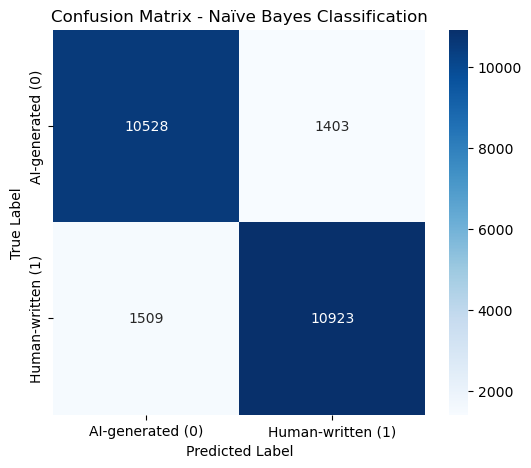

[[10528  1403]
 [ 1509 10923]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11931
           1       0.89      0.88      0.88     12432

    accuracy                           0.88     24363
   macro avg       0.88      0.88      0.88     24363
weighted avg       0.88      0.88      0.88     24363



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

X = vectorizer.fit_transform(df["final_text"])  # Feature matrix
y = df["classification"]  # Labels (1 = Human, 0 = AI)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["AI-generated (0)", "Human-written (1)"]

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naïve Bayes Classification")
plt.show()

# Convert classification report to a DataFrame
report = classification_report(y_test, y_pred, target_names=["AI-generated (0)", "Human-written (1)"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display results in a formatted table
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))